In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transformations (convert grayscale to 3-channel RGB)
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
    transforms.Resize((224, 224)),  # Resize to match ResNet input
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for 3 channels
])

# Dataset paths (already preprocessed)
train_dir = "D:/Singularity101/processed-dataset-new-n/preprocessed_train"
val_dir = "D:/Singularity101/processed-dataset-new-n/preprocessed_val"

# Load dataset using ImageFolder with transformations
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

# Print dataset info
print(f"Class Labels: {train_dataset.classes}")
print(f"Train Set Size: {len(train_dataset)} images")
print(f"Validation Set Size: {len(val_dataset)} images")

Class Labels: ['fake', 'real']
Train Set Size: 2880 images
Validation Set Size: 360 images


In [7]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet50_Weights

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load ResNet-50 with pre-trained weights
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

# Modify final layer for binary classification
model.fc = nn.Linear(model.fc.in_features, 1)  # Output = 1 (real/fake)
model = model.to(device)

# Print model summary (optional)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
import torch.optim as optim

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
def train_model(model, train_loader, val_loader, epochs=10):
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # Ensure label shape
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

In [13]:
train_model(model, train_loader, val_loader, epochs=25)

Epoch [1/25], Loss: 0.2571
Epoch [2/25], Loss: 0.0608
Epoch [3/25], Loss: 0.0427
Epoch [4/25], Loss: 0.0342
Epoch [5/25], Loss: 0.0206
Epoch [6/25], Loss: 0.0339
Epoch [7/25], Loss: 0.0344
Epoch [8/25], Loss: 0.0168
Epoch [9/25], Loss: 0.0302
Epoch [10/25], Loss: 0.0233
Epoch [11/25], Loss: 0.0164
Epoch [12/25], Loss: 0.0232
Epoch [13/25], Loss: 0.0154
Epoch [14/25], Loss: 0.0214
Epoch [15/25], Loss: 0.0437
Epoch [16/25], Loss: 0.0242
Epoch [17/25], Loss: 0.0114
Epoch [18/25], Loss: 0.0044
Epoch [19/25], Loss: 0.0034
Epoch [20/25], Loss: 0.0031
Epoch [21/25], Loss: 0.0020
Epoch [22/25], Loss: 0.0011
Epoch [23/25], Loss: 0.0037
Epoch [24/25], Loss: 0.0024
Epoch [25/25], Loss: 0.0029


In [15]:
import torch
import torch.nn as nn

# Set model to evaluation mode
model.eval()

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function
criterion = nn.BCEWithLogitsLoss()  # Because output layer has no activation

# Initialize variables
correct = 0
total = 0
val_loss = 0.0

# No gradient calculation for evaluation
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)  # Ensure correct shape
        
        outputs = model(images)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

        # Convert logits to binary predictions (0 or 1)
        predicted = torch.round(torch.sigmoid(outputs))
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

# Compute accuracy and average loss
accuracy = 100 * correct / total
avg_val_loss = val_loss / len(val_loader)

print(f"Validation Accuracy: {accuracy:.2f}%")
print(f"Validation Loss: {avg_val_loss:.4f}")

Validation Accuracy: 99.44%
Validation Loss: 0.0135


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score

y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        predicted = torch.round(torch.sigmoid(outputs))
        
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)

print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

Precision: 0.9890, Recall: 1.0000, F1-score: 0.9945


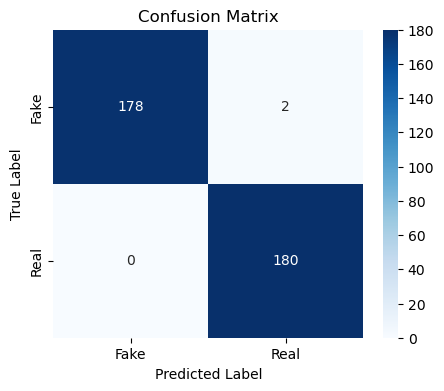

In [19]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Collect predictions and true labels
y_true = []
y_pred = []

model.eval()  # Set to evaluation mode
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        predicted = torch.round(torch.sigmoid(outputs))

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Fake", "Real"], yticklabels=["Fake", "Real"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [42]:
from PIL import Image
import torchvision.transforms as transforms
import torch

def predict_image(image_path, model, device):
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
    transforms.Resize((224, 224)),  # Resize to match ResNet input
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for 3 channels
])
    
    image = Image.open(image_path).convert("RGB")  # Keep it RGB (3 channels)
    image = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    model.eval()
    with torch.no_grad():
        output = model(image)
        prediction = torch.round(torch.sigmoid(output)).item()
    
    return "Real" if prediction == 1 else "Fake"

# Example usage
print(predict_image("024_073_8_png.rf.6e2abf6d730a7cf1d0f0a17f715726f4.jpg", model, device))

Real


In [38]:
correct = 0
total = 0

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
        outputs = model(images)
        predictions = torch.round(torch.sigmoid(outputs))
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

accuracy = correct / total
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 99.44%


In [31]:
torch.save(model.state_dict(), "deepfake_detector.pth")

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models as models

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the trained model
model = models.resnet50()
model.fc = nn.Linear(model.fc.in_features, 1)  # Binary classification (Real/Fake)
model.load_state_dict(torch.load("deepfake_detector.pth", map_location=device))  # Load .pth file
model = model.to(device)
model.eval()  # Set to evaluation mode

# Define image preprocessing
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # Convert grayscale to 3-channel
    transforms.Resize((224, 224)),  # Resize to match ResNet input
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for 3 channels
])

# Function to predict an image
def predict_image(image_path):
    image = Image.open(image_path).convert("RGB")  # Ensure it's in RGB mode
    image = transform(image).unsqueeze(0).to(device)  # Apply transformations and add batch dimension
    
    with torch.no_grad():
        output = model(image).item()  # Get raw output
        print(output)
    
    prediction = "Real" if output >=0 else "Fake"
    print(f"Prediction: {prediction}")

# Example usage
predict_image("001_8_png.rf.767bd9d16f6aef233b8d3474082002a7.jpg")

C:\Users\khadi\AppData\Local\Temp\ipykernel_24244\2455722962.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("deepfake_detector.pth", m

18.7647762298584
Prediction: Real


In [ ]:
import cv2
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.models import ResNet50_Weights
from PIL import Image
import numpy as np

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load pre-trained ResNet50
model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
model.fc = nn.Linear(model.fc.in_features, 1)  # Binary classification
model = model.to(device)

# Load trained weights (change path to your model)
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()

# Define transform (must match training transform)
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Grayscale(num_output_channels=3),  # Match training
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5]*3, std=[0.5]*3)
])

# Function to extract and classify frames
def predict_video(video_path, frame_interval=10, max_frames=100):
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    predictions = []

    while cap.isOpened() and frame_count < max_frames:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_count % frame_interval == 0:
            # Convert frame using same transform
            img = transform(frame).unsqueeze(0).to(device)
            with torch.no_grad():
                output = model(img)
                prob = torch.sigmoid(output).item()
                predictions.append(prob)
                print(f"Frame {frame_count}: {'Fake' if prob > 0.5 else 'Real'} ({prob:.2f})")

        frame_count += 1

    cap.release()

    if predictions:
        avg_score = sum(predictions) / len(predictions)
        final = "Fake" if avg_score > 0.5 else "Real"
        print(f"\nFinal Verdict: {final} (Avg Score: {avg_score:.2f})")
    else:
        print("No frames processed.")

# Run on your video (change path)
predict_video("input_video.mp4")
